In [1]:
%matplotlib inline
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models

from NetworkAPI import NetworkAPI

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data loaders

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.RandomCrop(28, padding=4),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', 
                                                  transform=data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=256, 
                                              shuffle=True, 
                                              num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Network architecture template

```
class Network(nn.Module):
    def __init__(self):
        super(NetworkMaxMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
#             nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
#             nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
```

# Pooling tests

20 epochs

2 sekwencje: Conv, ReLU, Batch, Conv, ReLU, Batch, Pool

Wszystkie kombinacje Pooli:

* Max -- Max
* Max -- Avg
* Avg -- Max
* Avg -- Avg

In [3]:
eps = 30

## Max -- Max

In [4]:
class NetworkMaxMax(nn.Module):
    def __init__(self):
        super(NetworkMaxMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x64x64
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  24.69s | Train loss:  2.15 | Train acc: 33.09|
| Epoch:   1 | Time:  12.50s | Val loss:    2.07 | Val acc:   39.13|
--------------------------------------------------------------------
| Epoch:   2 | Time:  23.33s | Train loss:  2.01 | Train acc: 45.11|
| Epoch:   2 | Time:  14.97s | Val loss:    1.97 | Val acc:   49.22|
--------------------------------------------------------------------
| Epoch:   3 | Time:  23.66s | Train loss:  1.96 | Train acc: 50.67|
| Epoch:   3 | Time:  13.37s | Val loss:    1.92 | Val acc:   54.24|
--------------------------------------------------------------------
| Epoch:   4 | Time:  22.95s | Train loss:  1.91 | Train acc: 56.06|
| Epoch:   4 | Time:  13.72s | Val loss:    1.86 | Val acc:   60.73|
--------------------------------------------------------------------
| Epoch:  

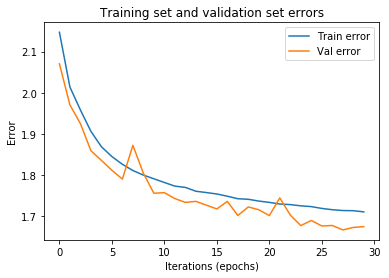

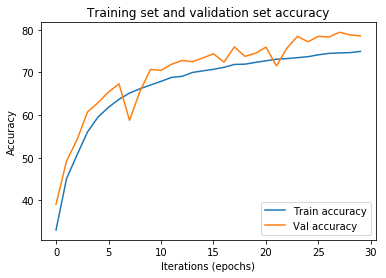

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 85.88% | 85.44%|
| Accuracy of: automobile | 85.00% | 85.10%|
| Accuracy of: bird       | 59.80% | 59.72%|
| Accuracy of: cat        | 64.90% | 64.98%|
| Accuracy of: deer       | 79.96% | 79.90%|
| Accuracy of: dog        | 70.64% | 70.76%|
| Accuracy of: frog       | 84.12% | 84.02%|
| Accuracy of: horse      | 82.18% | 82.22%|
| Accuracy of: ship       | 82.16% | 82.68%|
| Accuracy of: truck      | 90.76% | 90.76%|


In [5]:
np.random.seed = 0

model = NetworkMaxMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Max -- Avg

In [6]:
class NetworkMaxAvg(nn.Module):
    def __init__(self):
        super(NetworkMaxAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  23.17s | Train loss:  2.17 | Train acc: 30.86|
| Epoch:   1 | Time:  13.42s | Val loss:    2.06 | Val acc:   40.86|
--------------------------------------------------------------------
| Epoch:   2 | Time:  23.35s | Train loss:  2.02 | Train acc: 44.62|
| Epoch:   2 | Time:  13.17s | Val loss:    1.97 | Val acc:   49.90|
--------------------------------------------------------------------
| Epoch:   3 | Time:  23.16s | Train loss:  1.95 | Train acc: 51.28|
| Epoch:   3 | Time:  13.45s | Val loss:    1.92 | Val acc:   54.60|
--------------------------------------------------------------------
| Epoch:   4 | Time:  23.13s | Train loss:  1.91 | Train acc: 55.39|
| Epoch:   4 | Time:  13.26s | Val loss:    1.89 | Val acc:   57.54|
--------------------------------------------------------------------
| Epoch:  

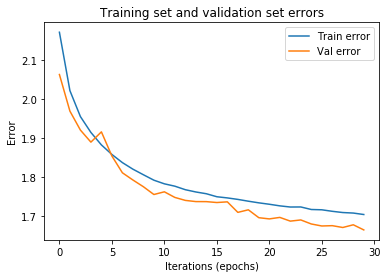

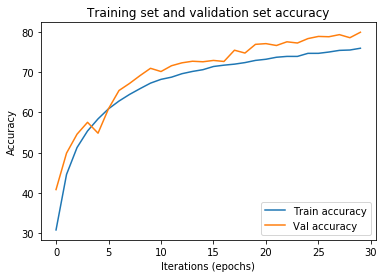

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 84.64% | 84.58%|
| Accuracy of: automobile | 91.28% | 91.60%|
| Accuracy of: bird       | 65.10% | 65.62%|
| Accuracy of: cat        | 58.68% | 58.16%|
| Accuracy of: deer       | 72.34% | 72.38%|
| Accuracy of: dog        | 74.78% | 75.14%|
| Accuracy of: frog       | 87.22% | 87.62%|
| Accuracy of: horse      | 83.42% | 83.60%|
| Accuracy of: ship       | 89.92% | 90.14%|
| Accuracy of: truck      | 90.12% | 89.88%|


In [7]:
np.random.seed = 0

model = NetworkMaxAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- Max

In [8]:
class NetworkAvgMax(nn.Module):
    def __init__(self):
        super(NetworkAvgMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  23.40s | Train loss:  2.13 | Train acc: 34.18|
| Epoch:   1 | Time:  13.06s | Val loss:    2.07 | Val acc:   39.42|
--------------------------------------------------------------------
| Epoch:   2 | Time:  23.46s | Train loss:  2.00 | Train acc: 47.01|
| Epoch:   2 | Time:  13.18s | Val loss:    1.97 | Val acc:   48.73|
--------------------------------------------------------------------
| Epoch:   3 | Time:  23.57s | Train loss:  1.95 | Train acc: 51.57|
| Epoch:   3 | Time:  13.23s | Val loss:    1.92 | Val acc:   54.54|
--------------------------------------------------------------------
| Epoch:   4 | Time:  23.65s | Train loss:  1.91 | Train acc: 55.08|
| Epoch:   4 | Time:  13.12s | Val loss:    1.91 | Val acc:   55.65|
--------------------------------------------------------------------
| Epoch:  

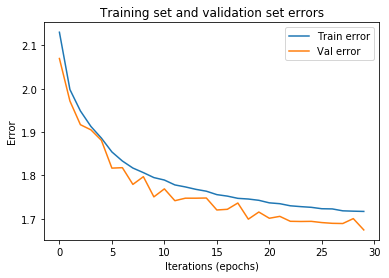

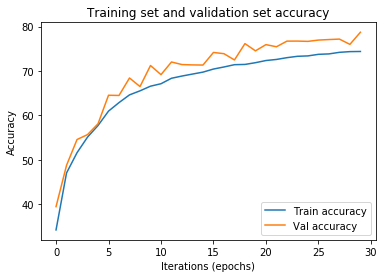

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 75.50% | 75.14%|
| Accuracy of: automobile | 89.86% | 89.66%|
| Accuracy of: bird       | 68.62% | 68.22%|
| Accuracy of: cat        | 65.14% | 63.72%|
| Accuracy of: deer       | 75.32% | 75.38%|
| Accuracy of: dog        | 66.92% | 67.48%|
| Accuracy of: frog       | 87.50% | 87.54%|
| Accuracy of: horse      | 81.04% | 81.20%|
| Accuracy of: ship       | 91.60% | 91.50%|
| Accuracy of: truck      | 86.98% | 87.24%|


In [9]:
np.random.seed = 0

model = NetworkAvgMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_MaxAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- Avg

In [10]:
class NetworkAvgAvg(nn.Module):
    def __init__(self):
        super(NetworkAvgAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x8x8
            nn.Dropout2d(0.3)
        )
        self.flatten = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*8*8)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  23.63s | Train loss:  2.19 | Train acc: 27.72|
| Epoch:   1 | Time:  13.15s | Val loss:    2.10 | Val acc:   35.70|
--------------------------------------------------------------------
| Epoch:   2 | Time:  24.05s | Train loss:  2.06 | Train acc: 40.10|
| Epoch:   2 | Time:  13.15s | Val loss:    2.12 | Val acc:   33.80|
--------------------------------------------------------------------
| Epoch:   3 | Time:  23.70s | Train loss:  2.01 | Train acc: 45.78|
| Epoch:   3 | Time:  13.43s | Val loss:    1.97 | Val acc:   49.11|
--------------------------------------------------------------------
| Epoch:   4 | Time:  23.66s | Train loss:  1.96 | Train acc: 50.67|
| Epoch:   4 | Time:  13.20s | Val loss:    1.95 | Val acc:   51.25|
--------------------------------------------------------------------
| Epoch:  

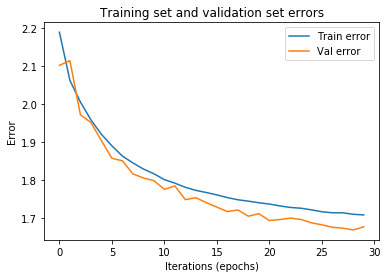

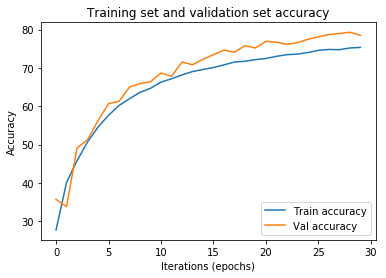

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 78.54% | 78.46%|
| Accuracy of: automobile | 91.10% | 91.38%|
| Accuracy of: bird       | 65.36% | 65.08%|
| Accuracy of: cat        | 59.10% | 59.00%|
| Accuracy of: deer       | 73.56% | 73.58%|
| Accuracy of: dog        | 67.06% | 66.50%|
| Accuracy of: frog       | 89.28% | 89.28%|
| Accuracy of: horse      | 80.44% | 80.66%|
| Accuracy of: ship       | 92.90% | 93.22%|
| Accuracy of: truck      | 87.64% | 87.90%|


In [11]:
np.random.seed = 0

model = NetworkAvgAvg().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
#brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- Max

In [12]:
class NetworkNoMax(nn.Module):
    def __init__(self):
        super(NetworkNoMax, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.MaxPool2d(kernel_size=2, stride=2), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  40.83s | Train loss:  2.08 | Train acc: 39.57|
| Epoch:   1 | Time:  17.88s | Val loss:    2.00 | Val acc:   46.08|
--------------------------------------------------------------------
| Epoch:   2 | Time:  41.07s | Train loss:  1.95 | Train acc: 51.86|
| Epoch:   2 | Time:  17.93s | Val loss:    1.94 | Val acc:   51.79|
--------------------------------------------------------------------
| Epoch:   3 | Time:  41.18s | Train loss:  1.89 | Train acc: 57.31|
| Epoch:   3 | Time:  17.83s | Val loss:    1.86 | Val acc:   60.76|
--------------------------------------------------------------------
| Epoch:   4 | Time:  41.04s | Train loss:  1.86 | Train acc: 60.31|
| Epoch:   4 | Time:  17.87s | Val loss:    1.84 | Val acc:   61.70|
--------------------------------------------------------------------
| Epoch:  

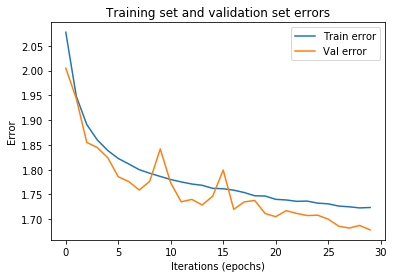

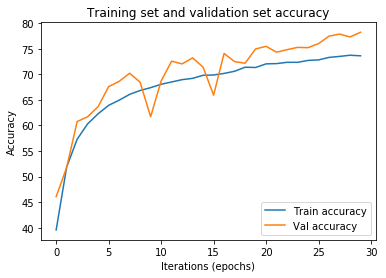

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 80.72% | 81.42%|
| Accuracy of: automobile | 89.12% | 88.80%|
| Accuracy of: bird       | 58.36% | 58.76%|
| Accuracy of: cat        | 61.16% | 61.72%|
| Accuracy of: deer       | 78.40% | 78.34%|
| Accuracy of: dog        | 69.42% | 69.56%|
| Accuracy of: frog       | 85.18% | 84.88%|
| Accuracy of: horse      | 84.28% | 84.34%|
| Accuracy of: ship       | 86.04% | 85.60%|
| Accuracy of: truck      | 88.70% | 88.80%|


In [13]:
np.random.seed = 0

model = NetworkNoMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoMax', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## No -- Avg

In [14]:
class NetworkNoAvg(nn.Module):
    def __init__(self):
        super(NetworkNoAvg, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Dropout2d(0.2) # Output is 32x32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x32x32
            nn.ReLU(inplace=True), # Output is 64x32x32
            nn.BatchNorm2d(64), # Output is 64x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  40.91s | Train loss:  2.09 | Train acc: 38.32|
| Epoch:   1 | Time:  18.26s | Val loss:    1.98 | Val acc:   49.26|
--------------------------------------------------------------------
| Epoch:   2 | Time:  40.97s | Train loss:  1.95 | Train acc: 51.23|
| Epoch:   2 | Time: 778.14s | Val loss:    1.90 | Val acc:   56.63|
--------------------------------------------------------------------
| Epoch:   3 | Time:  40.18s | Train loss:  1.90 | Train acc: 56.04|
| Epoch:   3 | Time:  17.88s | Val loss:    1.89 | Val acc:   57.42|
--------------------------------------------------------------------
| Epoch:   4 | Time:  40.95s | Train loss:  1.87 | Train acc: 59.32|
| Epoch:   4 | Time:  18.01s | Val loss:    1.87 | Val acc:   59.34|
--------------------------------------------------------------------
| Epoch:  

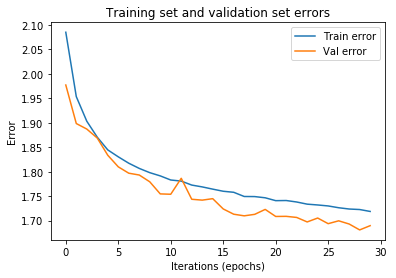

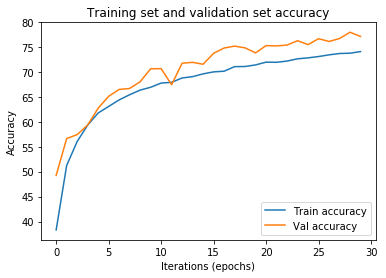

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 77.32% | 77.34%|
| Accuracy of: automobile | 83.00% | 82.32%|
| Accuracy of: bird       | 60.60% | 60.22%|
| Accuracy of: cat        | 68.02% | 67.32%|
| Accuracy of: deer       | 72.92% | 73.26%|
| Accuracy of: dog        | 75.38% | 75.50%|
| Accuracy of: frog       | 81.14% | 80.62%|
| Accuracy of: horse      | 79.58% | 79.56%|
| Accuracy of: ship       | 82.92% | 82.68%|
| Accuracy of: truck      | 91.98% | 92.20%|


In [15]:
np.random.seed = 0

model = NetworkNoMax().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_NoAvg', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)

## Avg -- No

In [16]:
class NetworkAvgNo(nn.Module):
    def __init__(self):
        super(NetworkAvgNo, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),# Output is 32x32x32
            nn.ReLU(inplace=True), # Output is 32x32x32
            nn.BatchNorm2d(32), # Output is 32x32x32
            nn.AvgPool2d(kernel_size=2, stride=2), # Output is 32x16x16
            nn.Dropout2d(0.2) # Output is 32x16x16
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),# Output is 64x16x16
            nn.ReLU(inplace=True), # Output is 64x16x16
            nn.BatchNorm2d(64), # Output is 64x16x16
            nn.Dropout2d(0.3)
        )
        
        self.flatten = nn.Sequential(
            nn.Linear(64*16*16, 256),
            nn.Linear(256,64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax(-1)
        )
    
    def forward(self,x):
        x = self.conv1(x) # Change size from 3x32x32 to 32x16x16
        x = self.conv2(x) # Change size from 32x16x16 to 64x16x16
        x = x.view(-1, 64*16*16)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

====== HYPERPARAMETERS ======
starting epoch= 0
epochs to go= 30
Starting learning rate= 0.1
--------------------------------------------------------------------
| Epoch:   1 | Time:  24.32s | Train loss:  2.12 | Train acc: 34.48|
| Epoch:   1 | Time:  13.45s | Val loss:    2.03 | Val acc:   43.52|
--------------------------------------------------------------------
| Epoch:   2 | Time:  24.33s | Train loss:  2.00 | Train acc: 46.47|
| Epoch:   2 | Time:  13.34s | Val loss:    1.98 | Val acc:   47.59|
--------------------------------------------------------------------
| Epoch:   3 | Time:  24.39s | Train loss:  1.95 | Train acc: 51.12|
| Epoch:   3 | Time:  13.32s | Val loss:    1.94 | Val acc:   51.98|
--------------------------------------------------------------------
| Epoch:   4 | Time:  24.32s | Train loss:  1.92 | Train acc: 54.59|
| Epoch:   4 | Time:  13.19s | Val loss:    1.87 | Val acc:   59.40|
--------------------------------------------------------------------
| Epoch:  

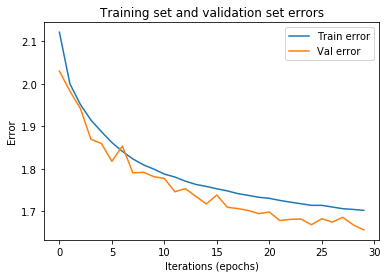

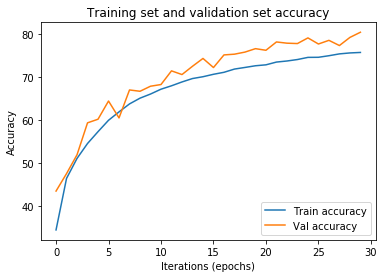

| Class                   | Train  | Test  |
--------------------------------------------
| Accuracy of: airplane   | 82.86% | 83.12%|
| Accuracy of: automobile | 89.80% | 89.90%|
| Accuracy of: bird       | 71.16% | 71.62%|
| Accuracy of: cat        | 59.00% | 58.90%|
| Accuracy of: deer       | 77.24% | 77.34%|
| Accuracy of: dog        | 72.54% | 72.76%|
| Accuracy of: frog       | 86.96% | 87.04%|
| Accuracy of: horse      | 84.94% | 84.62%|
| Accuracy of: ship       | 87.82% | 87.76%|
| Accuracy of: truck      | 91.82% | 91.74%|


In [17]:
np.random.seed = 0

model = NetworkAvgNo().to(device)
brain = NetworkAPI(model, dataloaders, 'arch_AvgNo', optim.SGD(model.parameters(), lr=0.1), lr=0.1)
# brain.load_checkpoint()
errors = brain.train_loop(epochs=eps)
brain.plot_errors()
brain.plot_accuracy()
brain.class_accuracy(class_names)